In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_identification.simulate import simulate_dataset

data = simulate_dataset()

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.001,
           detrend_type='constant', start_time=0, n_tapers=1)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional in

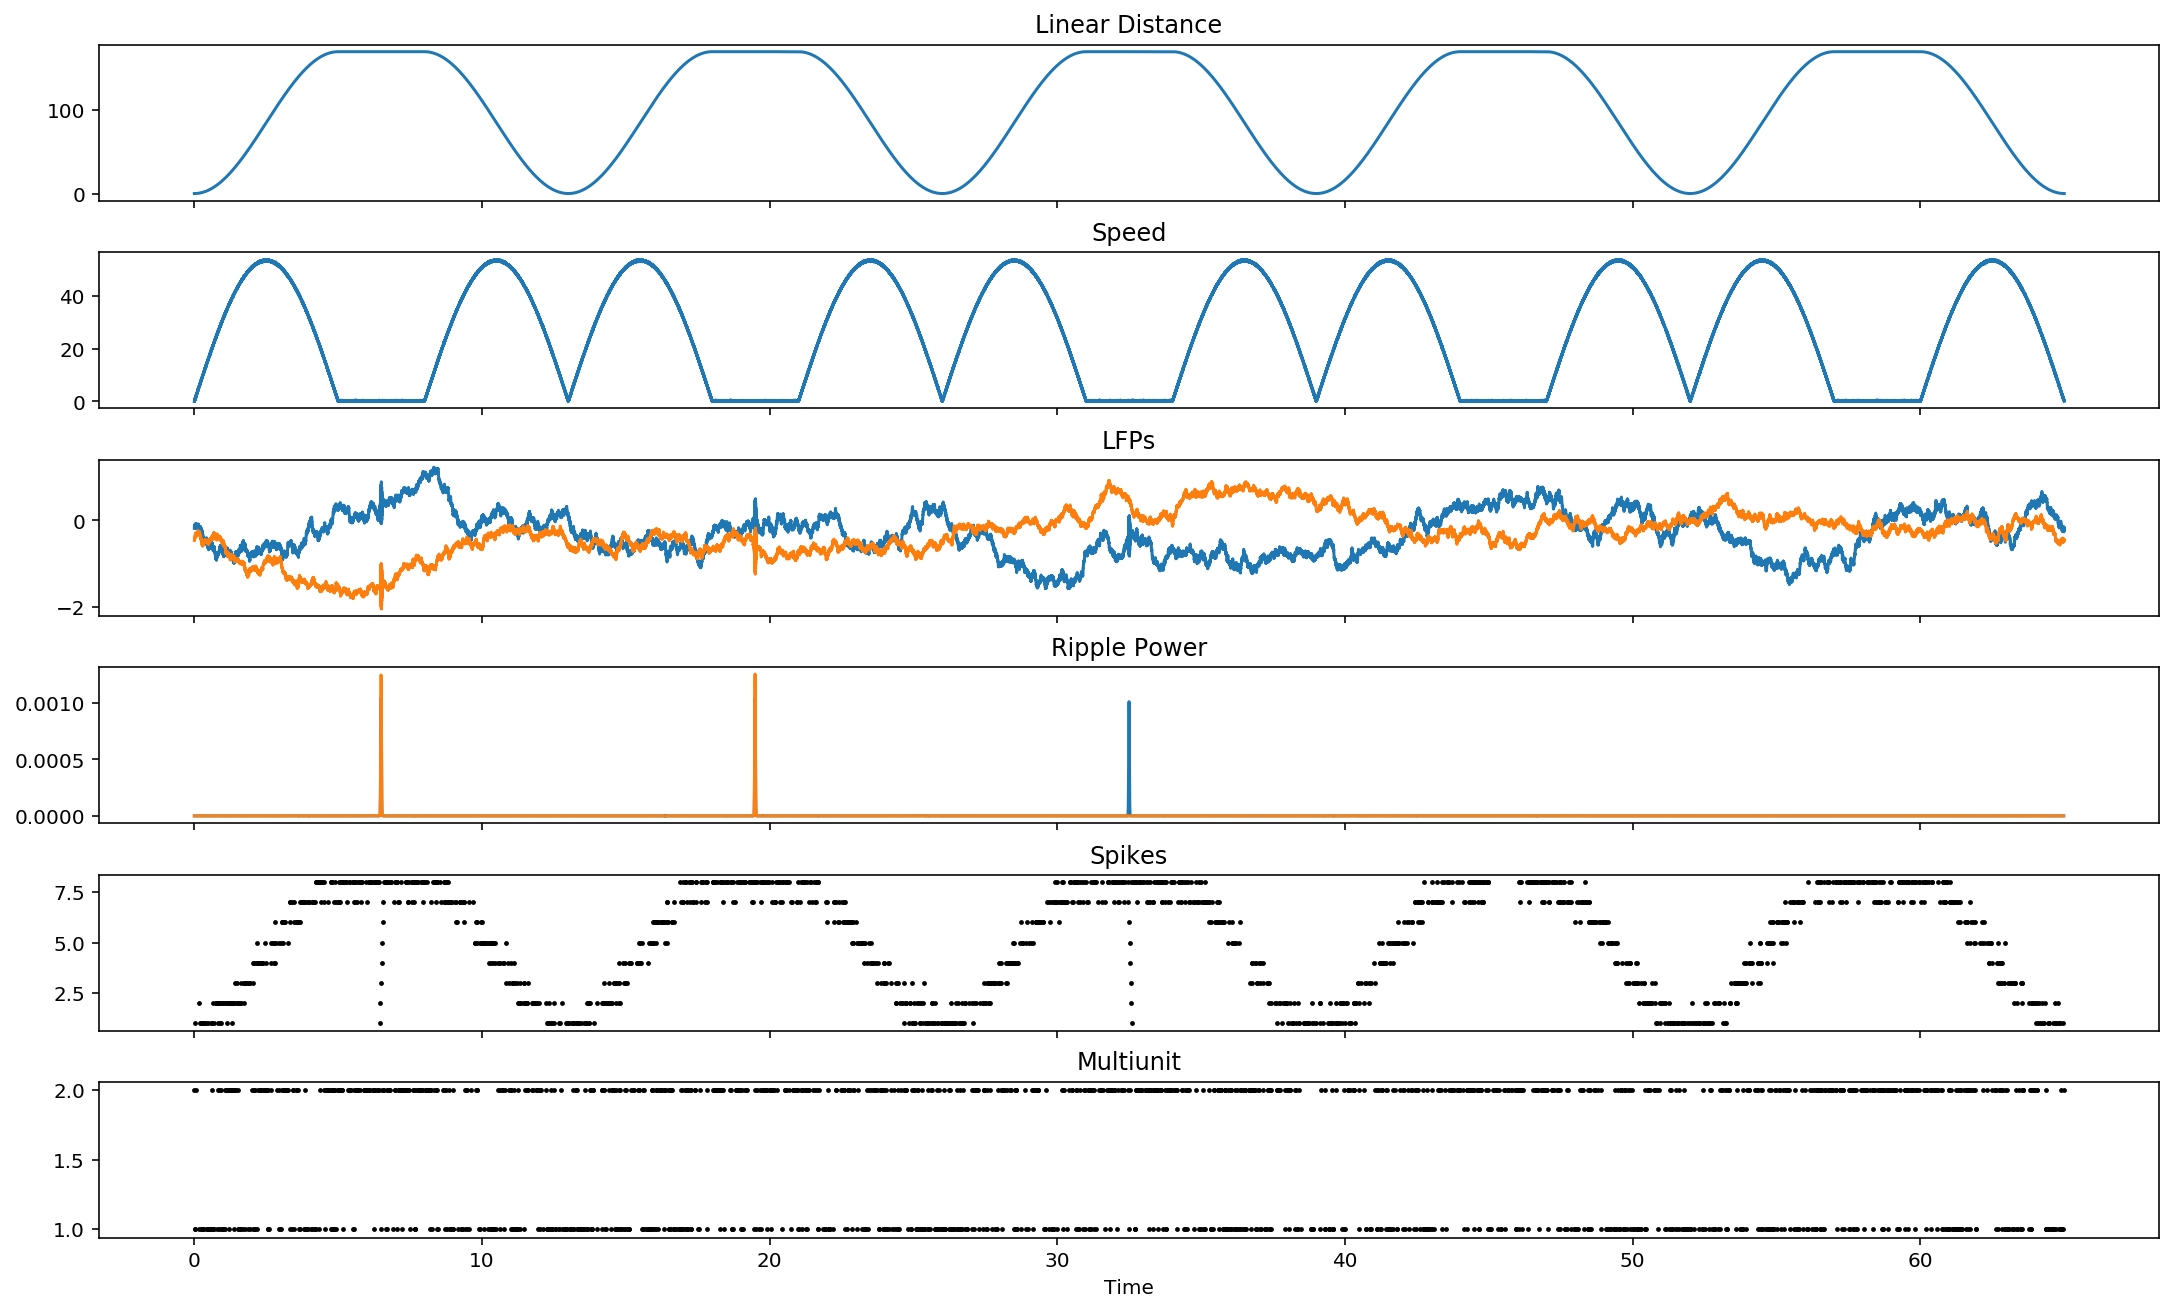

In [4]:
fig, axes = plt.subplots(6, 1, sharex=True, constrained_layout=True, figsize=(15, 9))

axes[0].plot(data['time'], data['linear_distance'])
axes[0].set_title('Linear Distance')

axes[1].plot(data['time'], data['speed'])
axes[1].set_title('Speed')

axes[2].plot(data['time'], data['lfps'])
axes[2].set_title('LFPs')

axes[3].plot(data['time'], data['ripple_power'])
axes[3].set_title('Ripple Power')

spike_time_ind, neuron_ind = np.nonzero(data['spikes'])
axes[4].scatter(data['time'][spike_time_ind], neuron_ind + 1, color='black', s=2)
axes[4].set_title('Spikes')

spike_time_ind, neuron_ind = np.nonzero(np.any(~np.isnan(data['multiunit']), axis=1))
axes[5].scatter(data['time'][spike_time_ind], neuron_ind + 1, color='black', s=2)
axes[5].set_title('Multiunit')

axes[-1].set_xlabel('Time');

### Set up grid

In [5]:
from replay_identification.core import get_grid

place_bin_size = 2.0
position_range = None
infer_track_interior = False
position = data['linear_distance']

(edges_, place_bin_edges_, place_bin_centers_,
 centers_shape_) = get_grid(
    position, place_bin_size, position_range,
    infer_track_interior)

### Continuous State Transition

(1, 1, 86, 86)


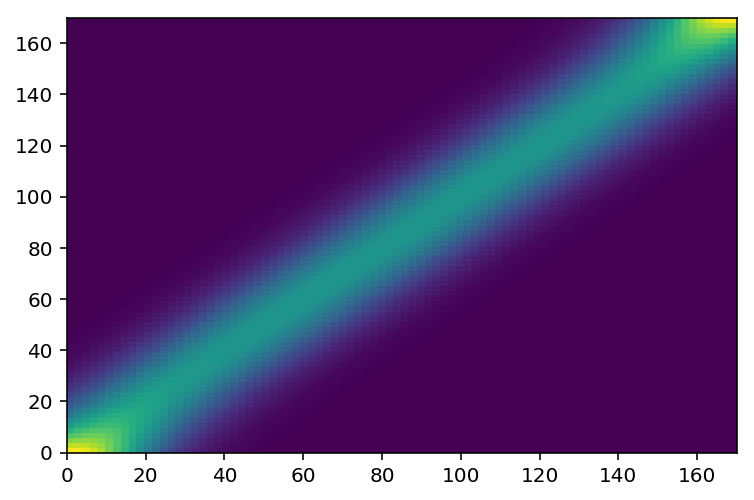

In [173]:
from replay_identification.movement_state_transition import random_walk, estimate_movement_var

sampling_frequency = data['sampling_frequency']
is_track_interior = np.ones((place_bin_centers_.shape[0],), dtype=np.bool)

movement_var = estimate_movement_var(position, sampling_frequency)

continuous_state_transition = random_walk(
    place_bin_centers_, movement_var, is_track_interior,
    replay_speed=200)
continuous_state_transition = continuous_state_transition[np.newaxis, np.newaxis, ...]
print(continuous_state_transition.shape)

plt.pcolormesh(place_bin_edges_.squeeze(), place_bin_edges_.squeeze(), continuous_state_transition.squeeze());

### Discrete State Transition

True
True


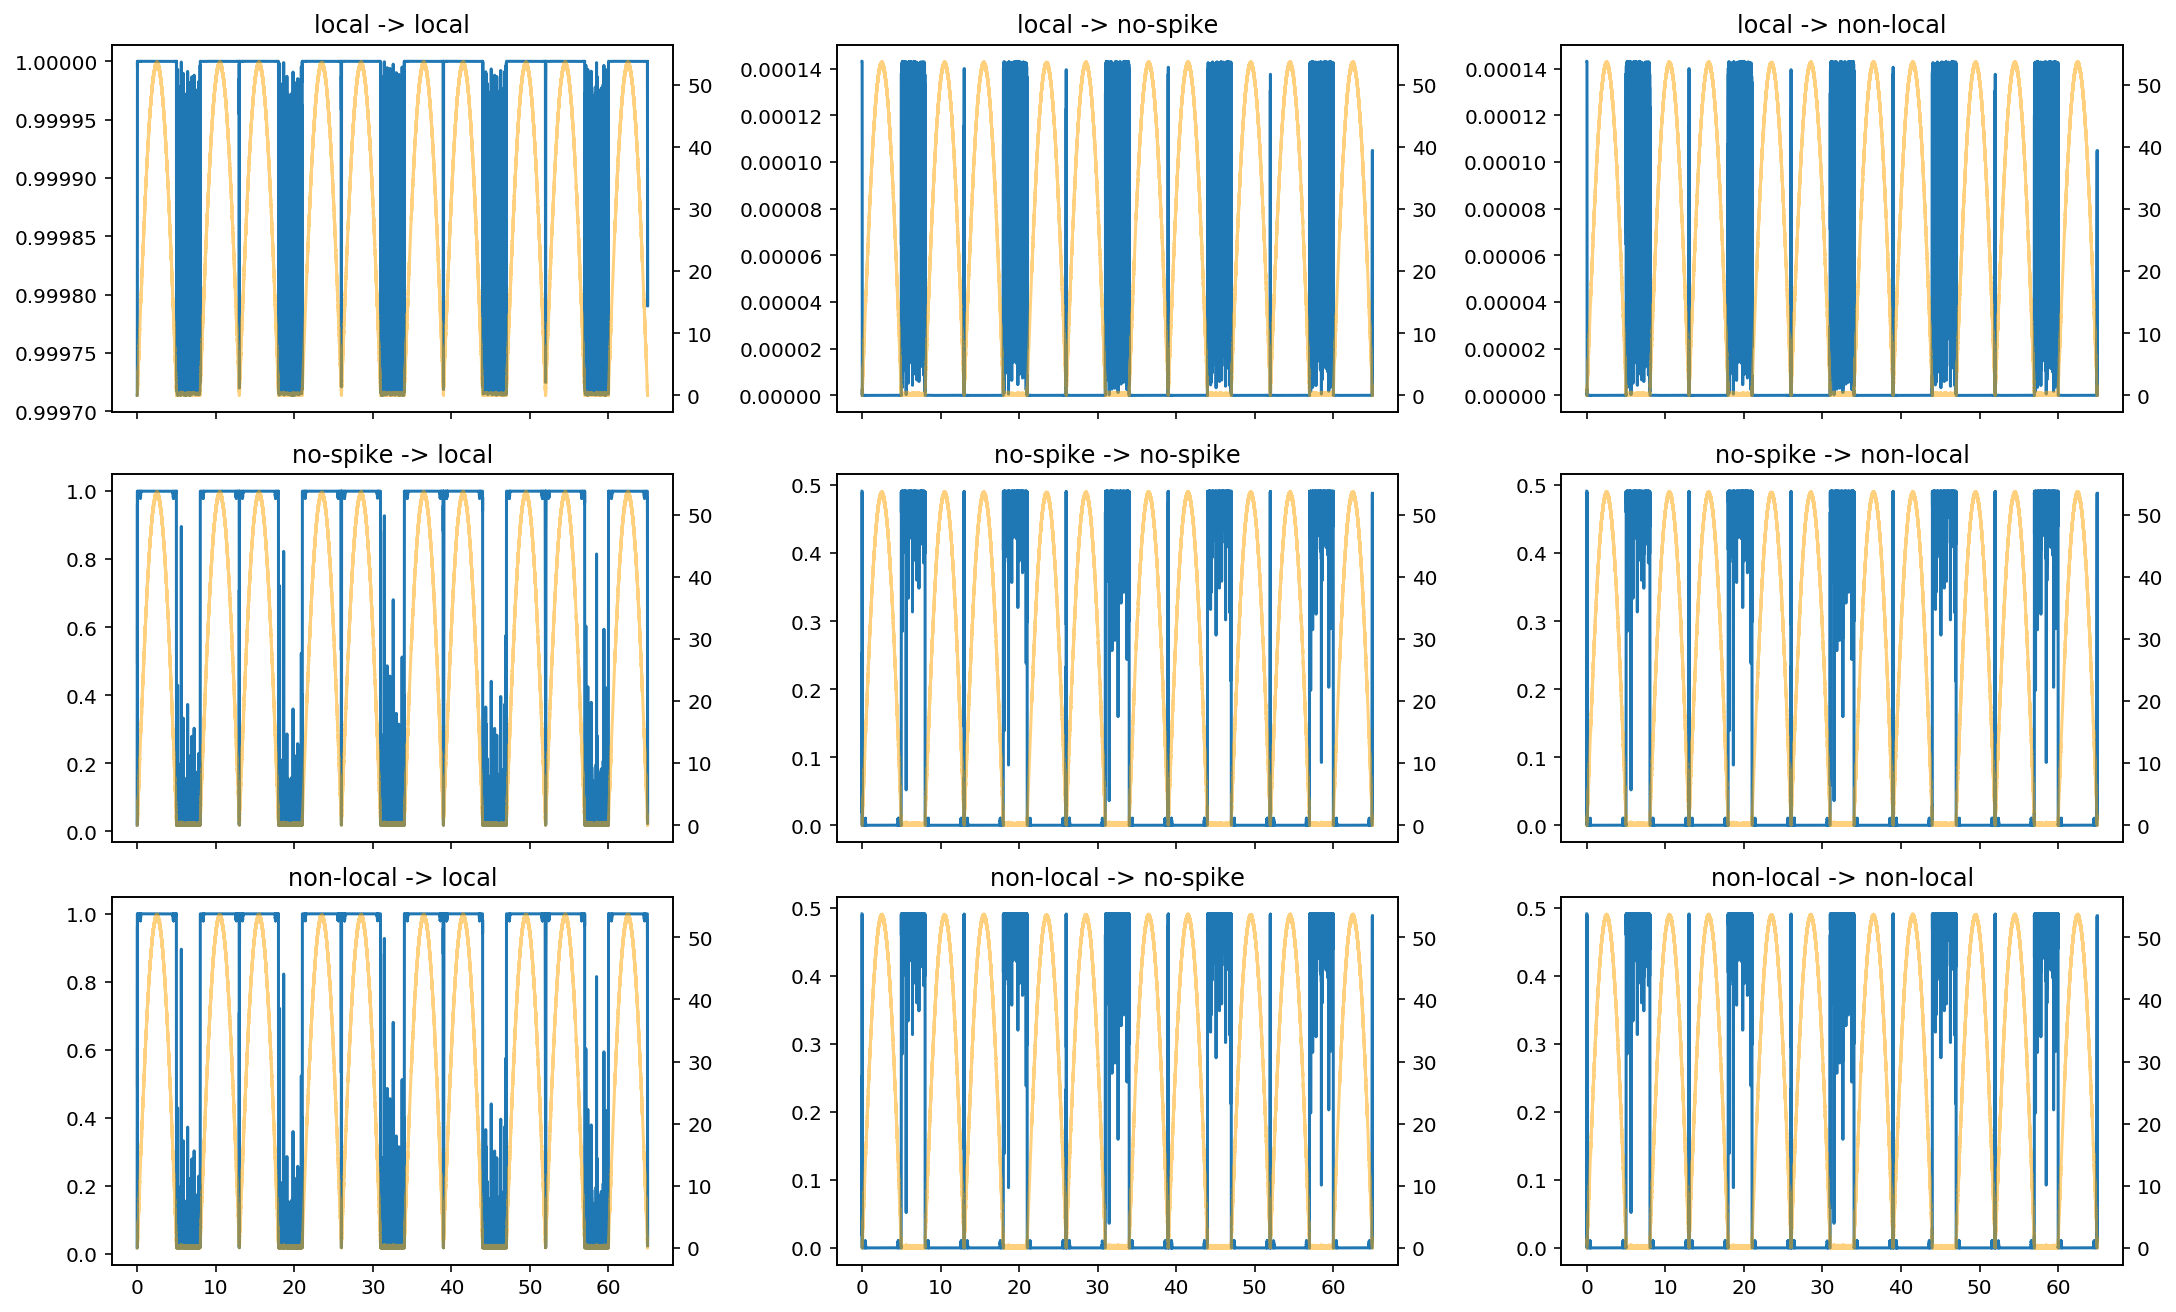

In [30]:
from replay_identification.replay_state_transition import fit_replay_state_transition
from statsmodels.tsa.tsatools import lagmat

n_time = data['time'].size
is_replay = data['is_training']
speed = data['speed']


state_names = ['local', 'no-spike', 'non-local']
n_discrete_states = 3 # local, no-spike, non-local
discrete_state_transition = np.zeros((n_time, n_discrete_states, n_discrete_states))

replay_state_transition = fit_replay_state_transition(speed, is_replay)
lagged_speed = lagmat(speed, maxlag=1).squeeze()
replay_state_transition = replay_state_transition(lagged_speed)
# replay_state_transition[:, 0] - p(replay | no_previous_replay)
# replay_state_transition[:, 1] - p(replay | previous_replay)
# 1 - replay_state_transition[:, 0] - p(no_replay | no_previous_replay)
# 1 - replay_state_transition[:, 1] - p(no_replay | previous_replay)

# local -> local
discrete_state_transition[:, 0, 0] = 1 - replay_state_transition[:, 0]

# local -> no-spike
discrete_state_transition[:, 0, 1] = replay_state_transition[:, 0] / 2.0

# local -> non-local
discrete_state_transition[:, 0, 2] = replay_state_transition[:, 0] / 2.0

# no-spike -> local
discrete_state_transition[:, 1, 0] = 1 - replay_state_transition[:, 1]

# no-spike -> no-spike
discrete_state_transition[:, 1, 1] = replay_state_transition[:, 1] / 2.0

# no-spike -> non-local
discrete_state_transition[:, 1, 2] = replay_state_transition[:, 1] / 2.0

# non-local -> local
discrete_state_transition[:, 2, 0] = 1 - replay_state_transition[:, 1]

# non-local -> no-spike
discrete_state_transition[:, 2, 1] = replay_state_transition[:, 1] / 2.0

# non-local -> non-local
discrete_state_transition[:, 2, 2] = replay_state_transition[:, 1] / 2.0

print(np.allclose(1.0, discrete_state_transition.sum(axis=2)))

discrete_state_transition /= discrete_state_transition.sum(axis=2, keepdims=True)

print(np.allclose(1.0, discrete_state_transition.sum(axis=2)))

fig, axes = plt.subplots(n_discrete_states, n_discrete_states, figsize=(15, 9), sharex=True, constrained_layout=True)
for i in range(3):
    for j in range(3):
        axes[i, j].plot(data['time'], discrete_state_transition[:, i, j])
        axes[i, j].set_title(f'{state_names[i]} -> {state_names[j]}')
        twin_ax = axes[i, j].twinx()
        twin_ax.plot(data['time'], data['speed'], zorder=0, alpha=0.5, color='orange')

### Continuous Likelihood

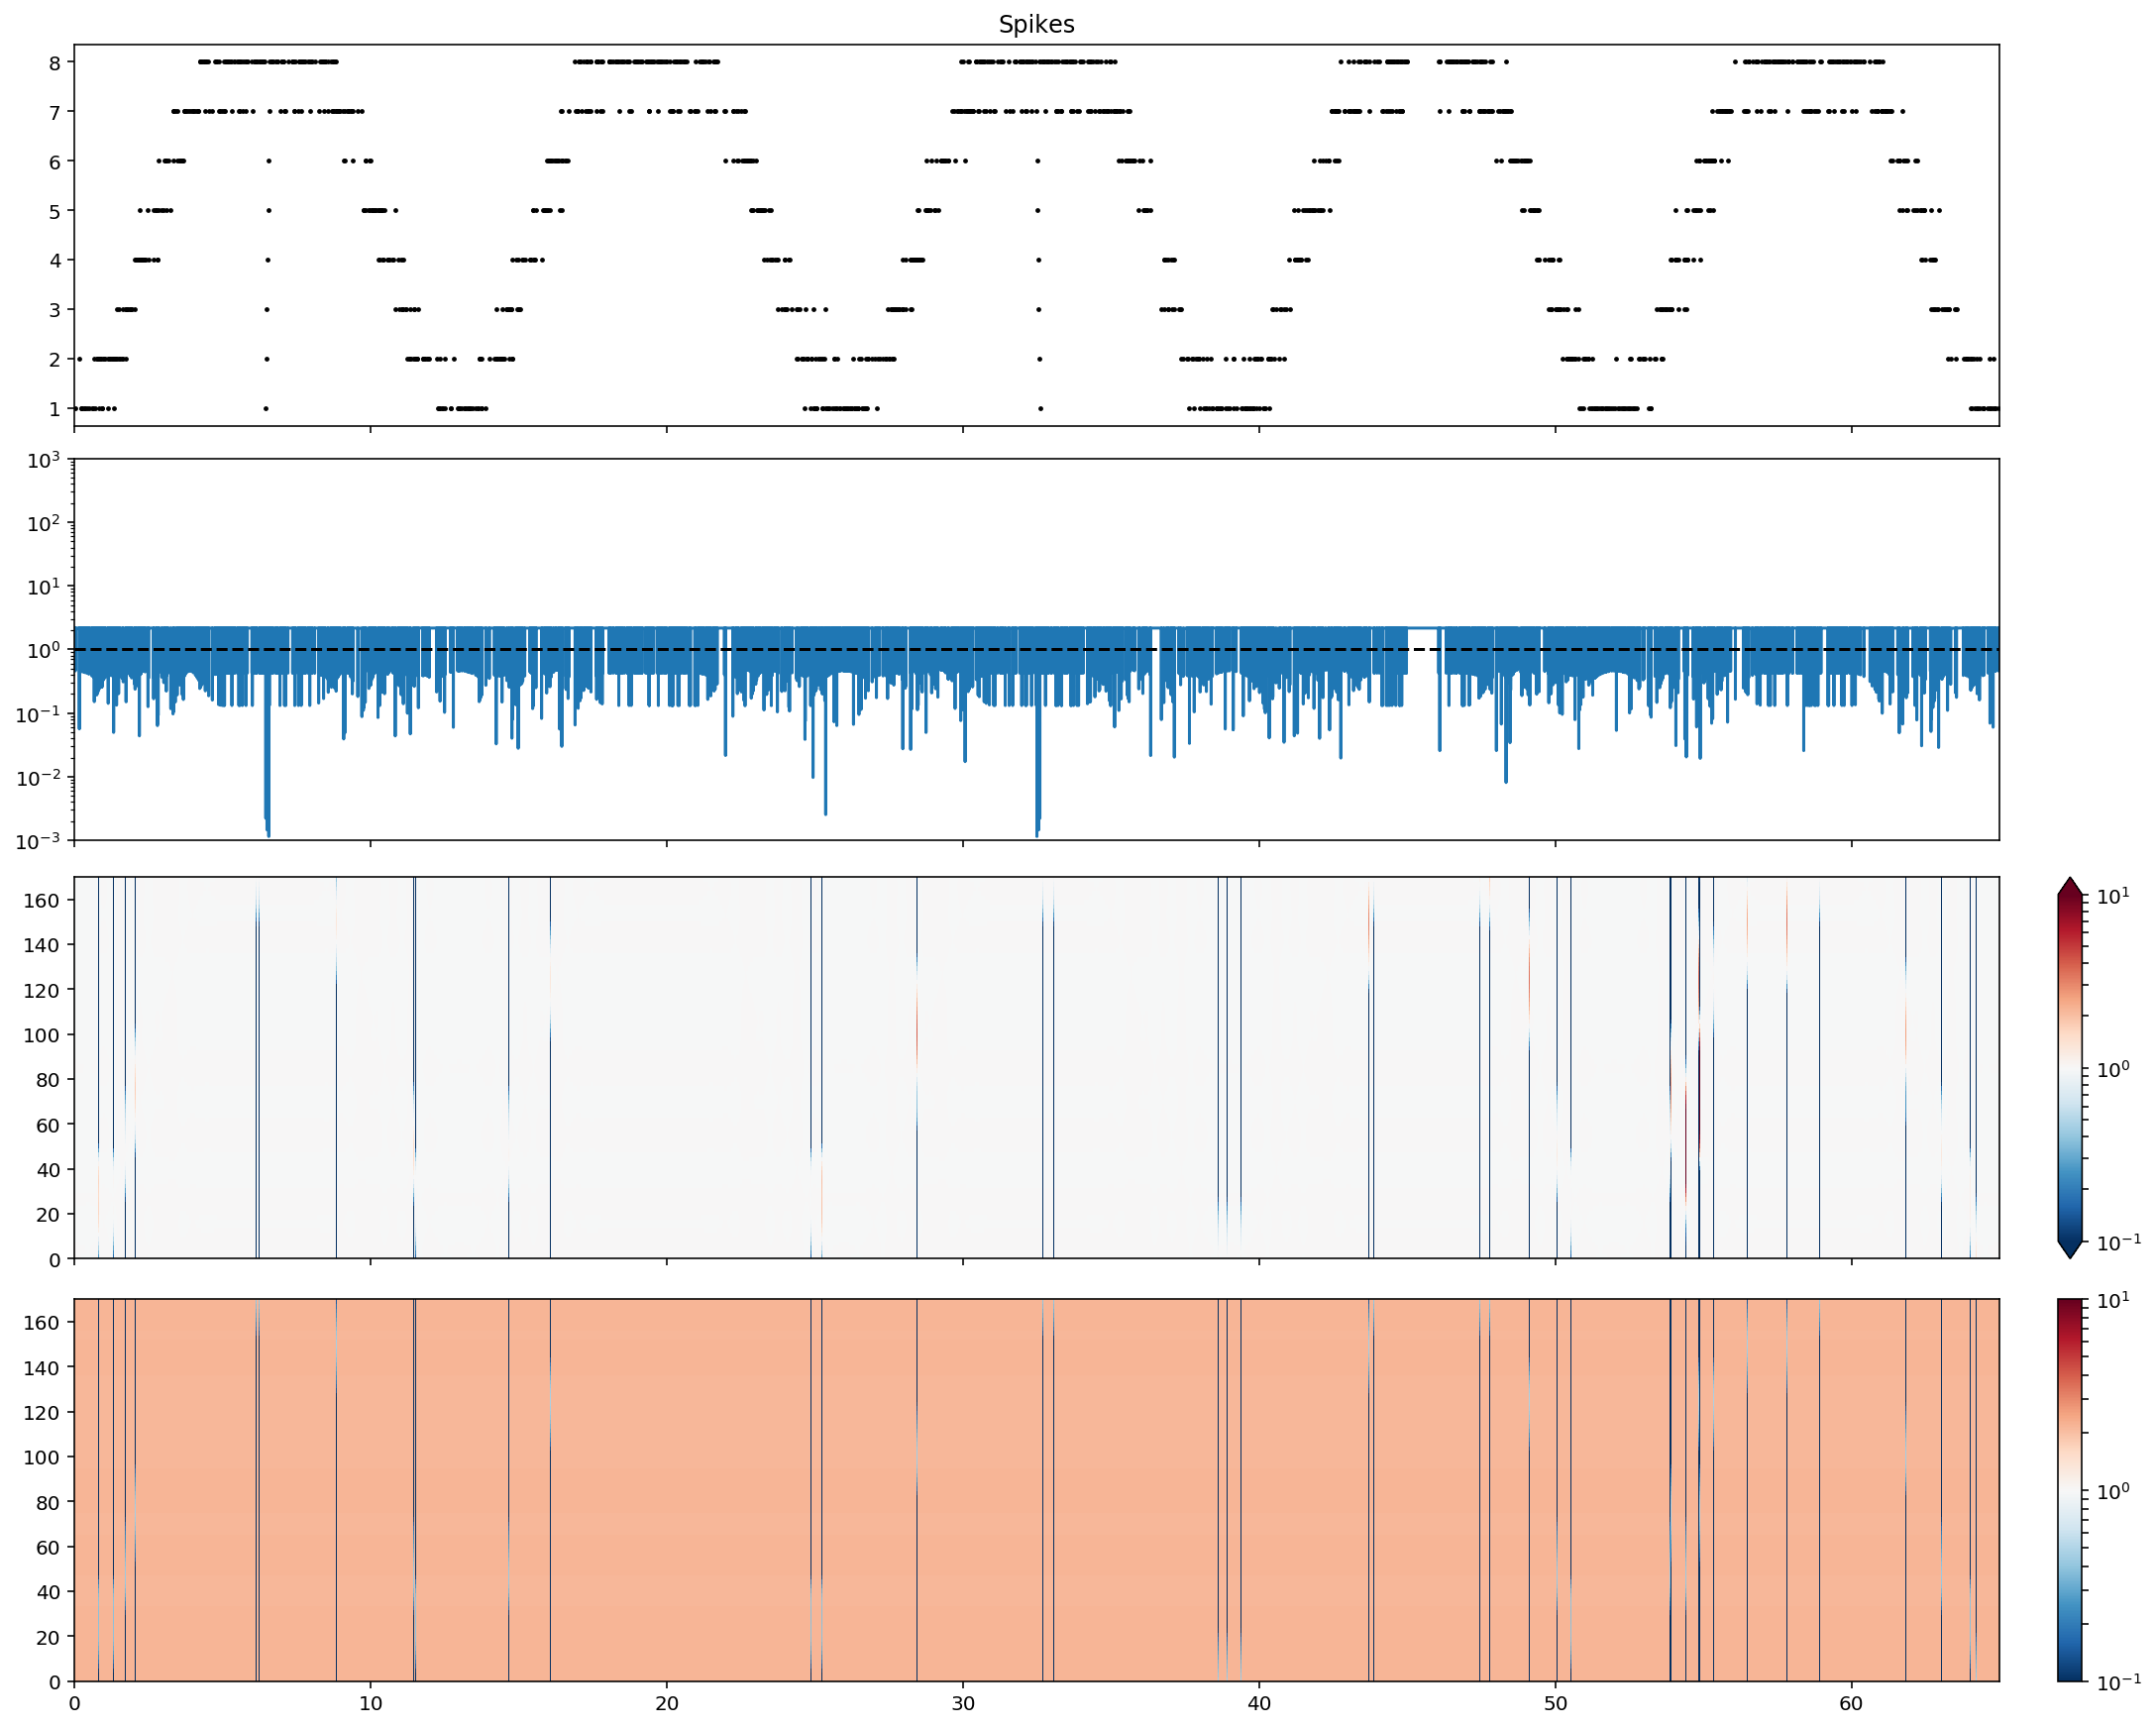

In [52]:
from replay_identification.spiking_likelihood import fit_spiking_likelihood

import matplotlib.colors as colors

spikes = data['spikes']
spike_model_penalty = 1E-1
spike_model_knot_spacing = 15

spiking_likelihood = fit_spiking_likelihood(
                position, spikes, is_replay, place_bin_centers_,
                spike_model_penalty, spike_model_knot_spacing)

spiking_likelihood = spiking_likelihood(spikes, position)

discrete_likelihood = spiking_likelihood[:, :2, 0] # (n_time, n_states)
continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)
# 0 - no replay (local)
# 1 - no spiking (no-spike)
# 2 - replay (non-local)


fig, axes = plt.subplots(4, 1, figsize=(15, 4 * 3), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(data['spikes'])
axes[0].scatter(data['time'][spike_time_ind], neuron_ind + 1, color='black', s=2)
axes[0].set_title('Spikes')

axes[1].plot(data['time'], discrete_likelihood[:, 0] / discrete_likelihood[:, 1])
axes[1].set_yscale('log')
axes[1].set_ylim((1E-3, 1E3))
axes[1].axhline(1, color='black', linestyle='--')

t, bins = np.meshgrid(data['time'], place_bin_edges_)
ratio = continuous_likelihood.squeeze() / discrete_likelihood[:, [0]]
h = axes[2].pcolormesh(t, bins, ratio.T, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=1E-1, vmax=1E1), cmap='RdBu_r');
plt.colorbar(h, ax=axes[2], extend='both')

ratio = continuous_likelihood.squeeze() / discrete_likelihood[:, [1]]
h = axes[3].pcolormesh(t, bins, ratio.T, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=1E-1, vmax=1E1), cmap='RdBu_r');
plt.colorbar(h, ax=axes[3])

(44, 48)

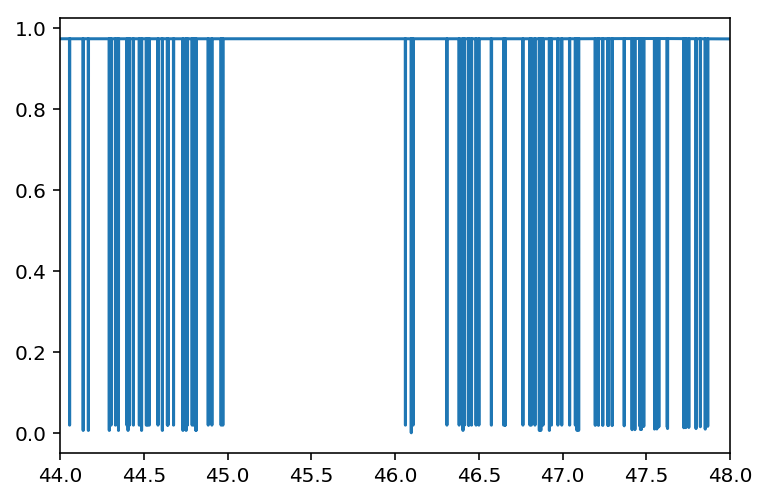

In [49]:
plt.plot(data['time'], discrete_likelihood[:, [0]]) # No-Replay
plt.xlim((44, 48))

(44, 48)

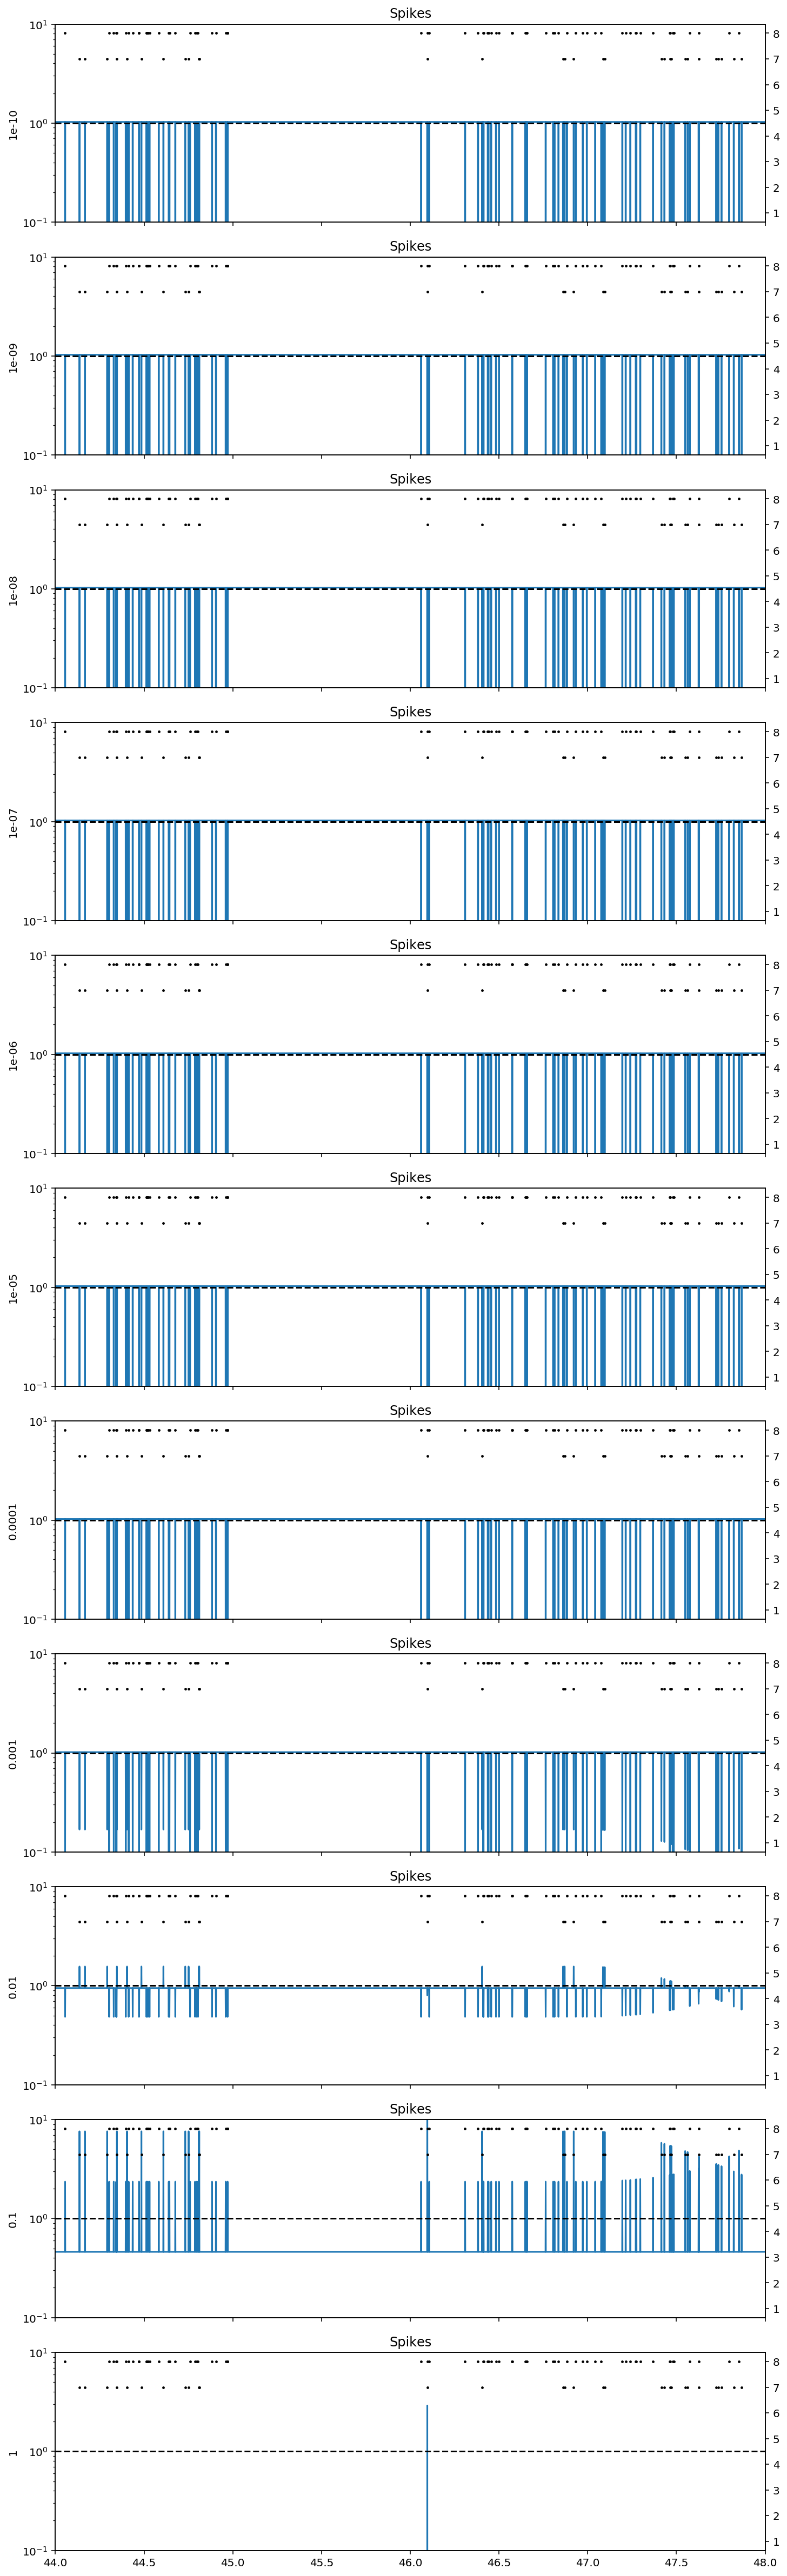

In [73]:
fig, axes = plt.subplots(11, 1, figsize=(10, 33), constrained_layout=True, sharex=True, sharey=True)

for i in range(-10, 1):

    spiking_likelihood = fit_spiking_likelihood(
                    position, spikes, is_replay, place_bin_centers_,
                    spike_model_penalty, spike_model_knot_spacing)
    spiking_likelihood = spiking_likelihood(spikes, position, no_spike_intensity=10**i)
    
    axes[i - 1].plot(data['time'], spiking_likelihood[:, 1, 0] / spiking_likelihood[:, 0, 0], label=i) # No Spike
    axes[i - 1].set_ylabel(10**i)
    axes[i - 1].axhline(1, color='black', linestyle='--')
    axes[i - 1].set_yscale('log')
    axes[i - 1].set_ylim((1E-1, 1E1))
    
    spike_time_ind, neuron_ind = np.nonzero(data['spikes'])
    twinx_ax = axes[i].twinx()
    twinx_ax.scatter(data['time'][spike_time_ind], neuron_ind + 1, color='black', s=2)
    twinx_ax.set_title('Spikes')
plt.xlim((44, 48))



True


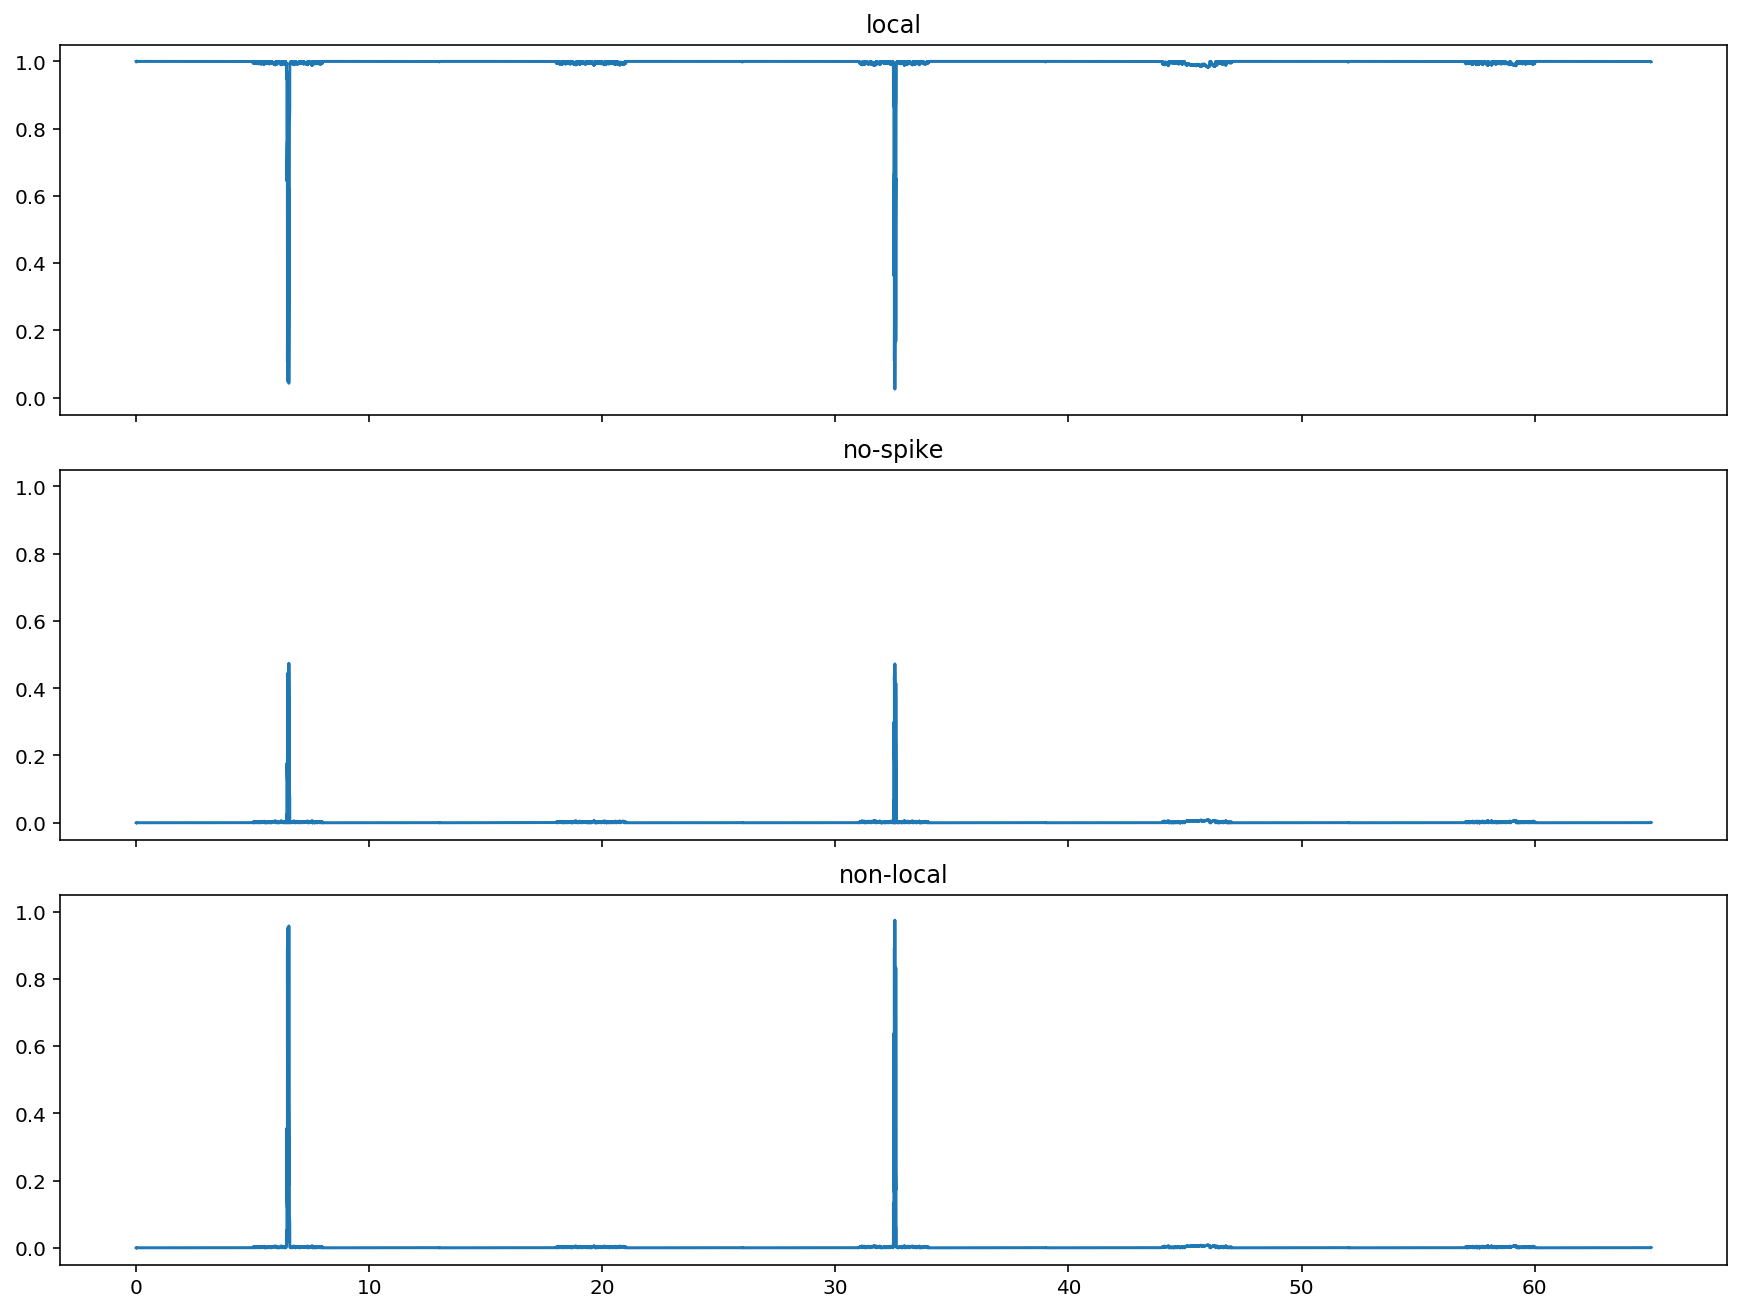

In [108]:
from replay_identification.core import _causal_classify2

# 0 = Local, 1 = No Spike, 2 = Non-Local
spiking_likelihood = fit_spiking_likelihood(
                position, spikes, is_replay, place_bin_centers_,
                spike_model_penalty, spike_model_knot_spacing)
spiking_likelihood = spiking_likelihood(spikes, position, no_spike_intensity=1e-10)
discrete_likelihood = spiking_likelihood[:, :2, 0] # (n_time, n_states)
continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)

continuous_posterior, state_probability = _causal_classify2(continuous_likelihood, discrete_likelihood,
                  continuous_state_transition,
                  discrete_state_transition)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, sharey=True, constrained_layout=True)
for i, ax in enumerate(axes):
    ax.plot(data['time'], state_probability[:, i])
    ax.set_title(state_names[i])



(0, 1)

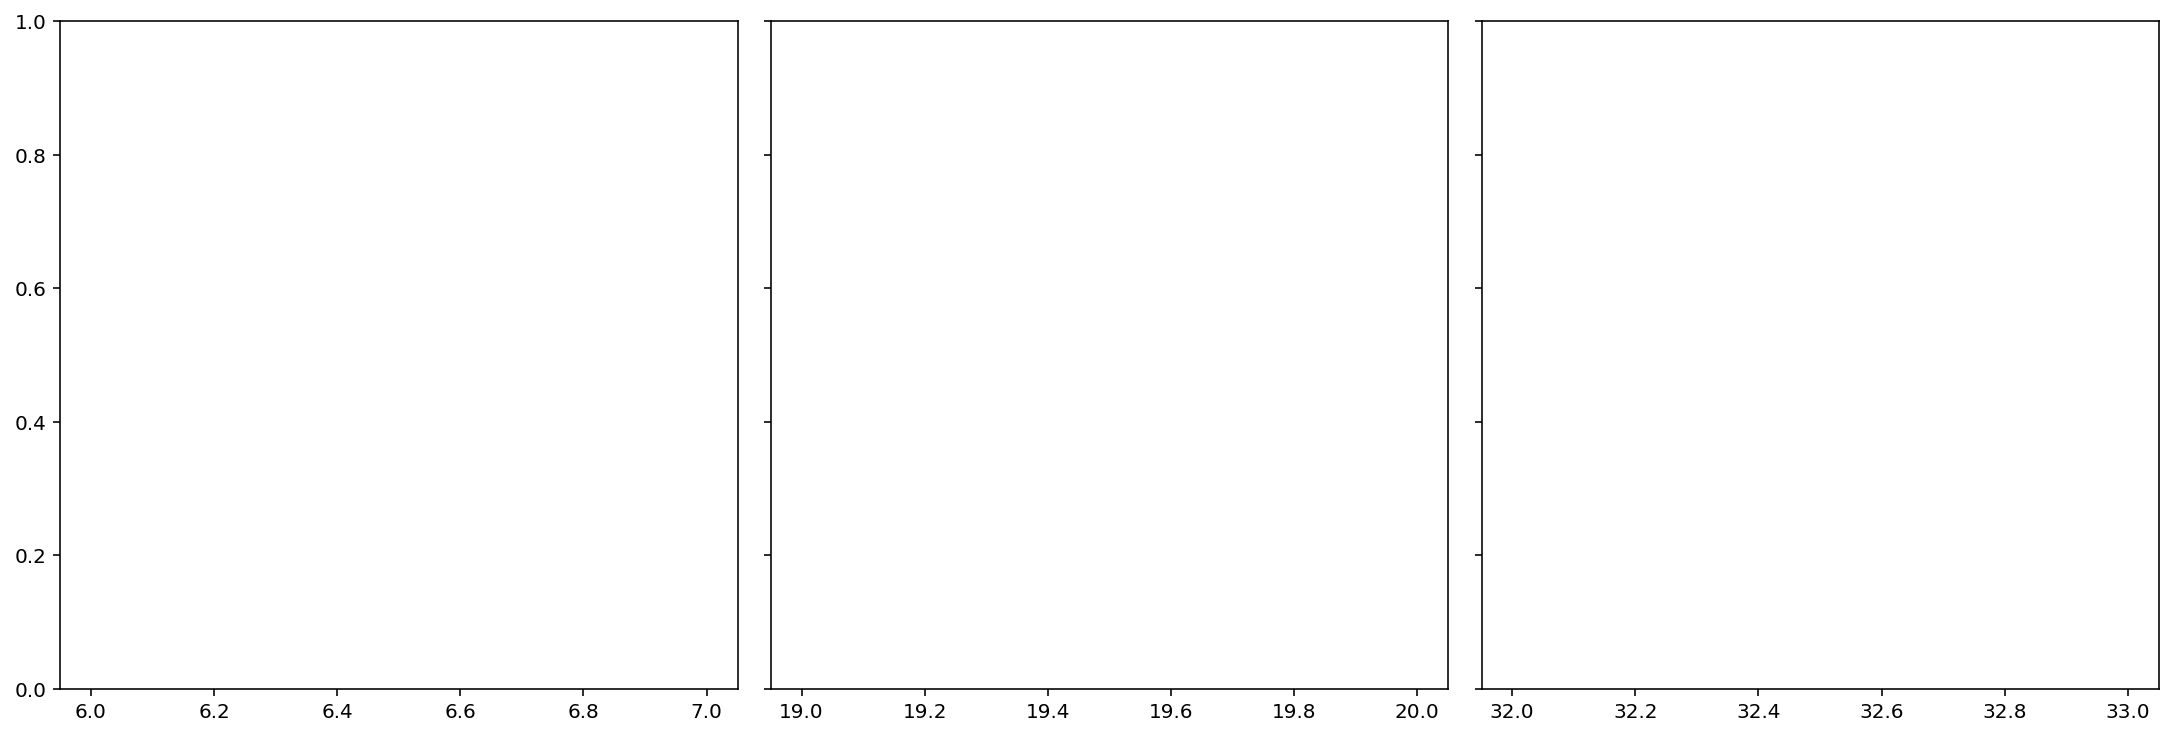

In [140]:
# 0 = Local, 1 = No Spike, 2 = Non-Local
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)

for i in range(-1, -10, -2):
    spiking_likelihood = fit_spiking_likelihood(
                    position, spikes, is_replay, place_bin_centers_,
                    spike_model_penalty, spike_model_knot_spacing)
    spiking_likelihood = spiking_likelihood(spikes, position, no_spike_intensity=10**i)
    discrete_likelihood = spiking_likelihood[:, :2, 0] # (n_time, n_states)
    continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)

    continuous_posterior, state_probability = _causal_classify2(continuous_likelihood, discrete_likelihood,
                      continuous_state_transition,
                      discrete_state_transition2)



    for ax, (start_time, end_time) in zip(axes, data['ripple_times']):
        ax.plot(data['time'], state_probability[:, 2])
        ax.set_xlim((start_time - 0.5, end_time + 0.5))

plt.ylim((0, 1))

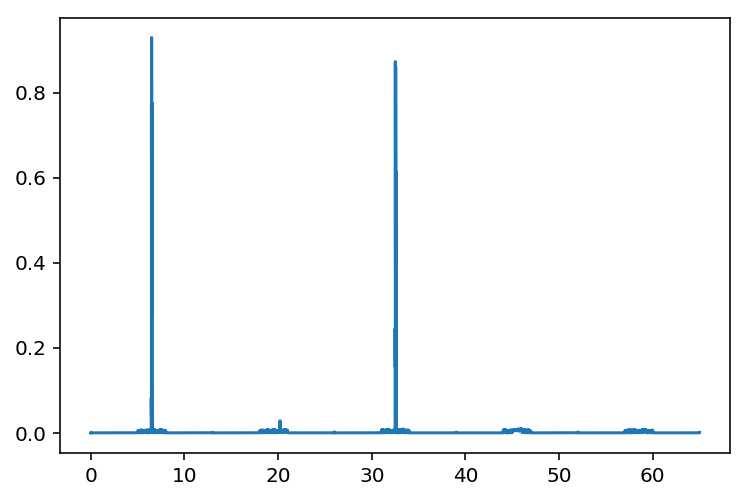

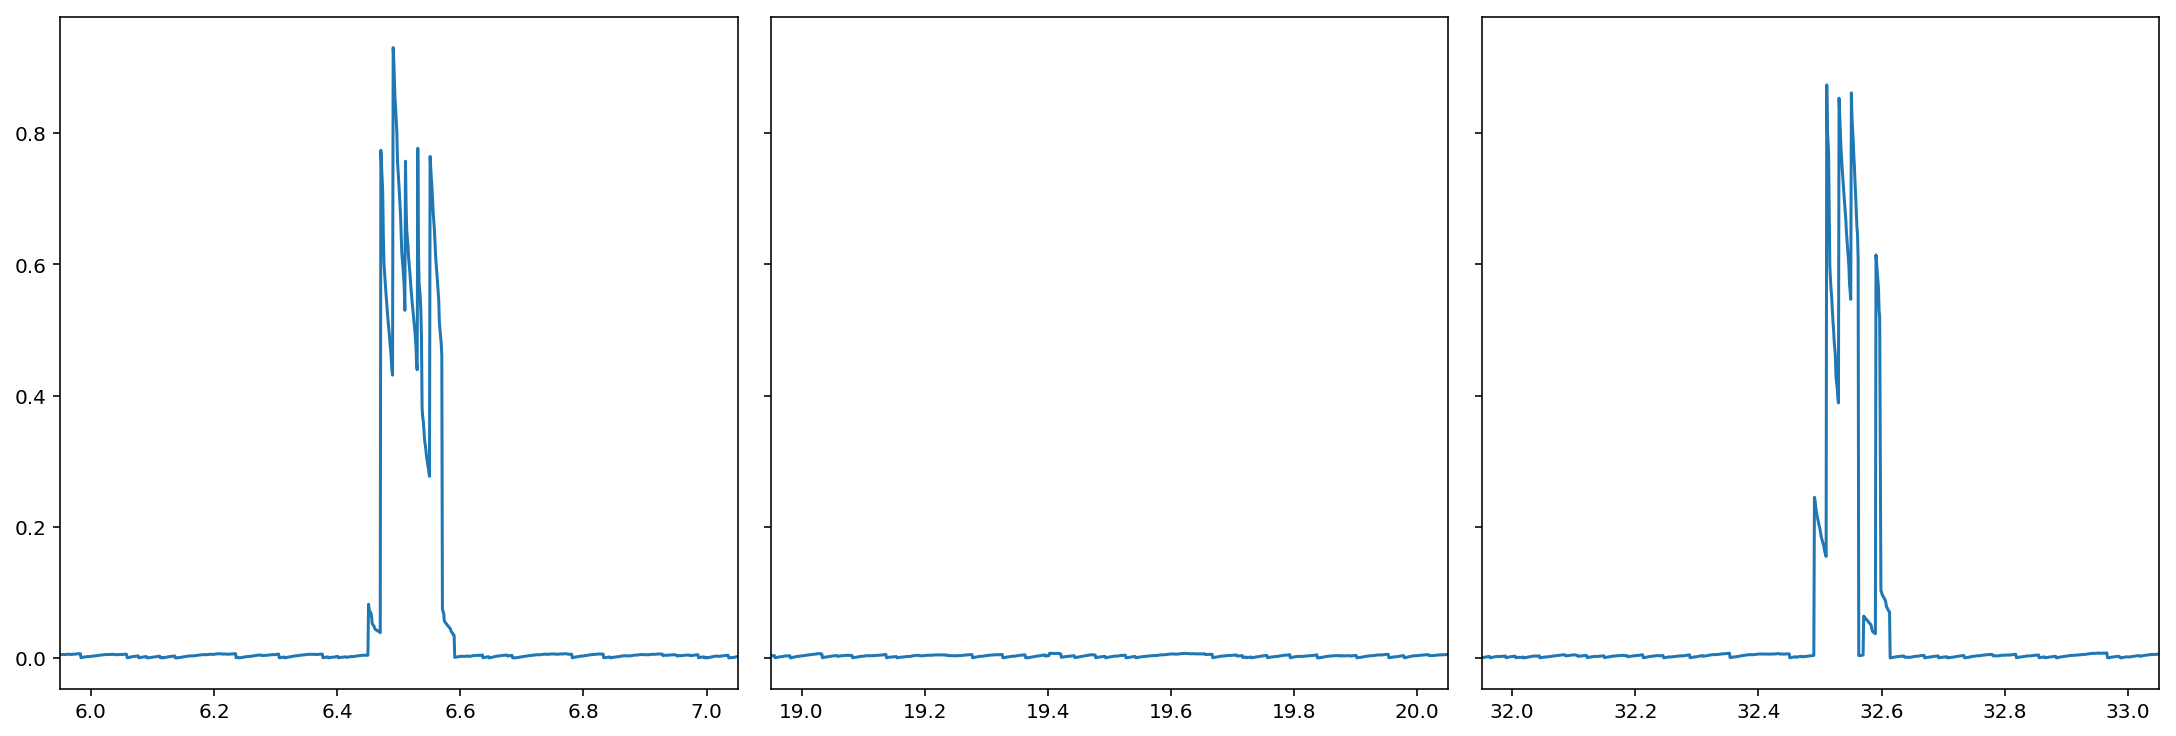

In [179]:
movement_var = estimate_movement_var(position, sampling_frequency)

continuous_state_transition = random_walk(
    place_bin_centers_, movement_var, is_track_interior,
    replay_speed=1)
continuous_state_transition = continuous_state_transition[np.newaxis, np.newaxis, ...]


discrete_state_transition2 = np.zeros((n_time, 2, 2))

# local -> local
discrete_state_transition2[:, 0, 0] = 1 - replay_state_transition[:, 0]

# local -> non-local
discrete_state_transition2[:, 0, 1] = replay_state_transition[:, 0]

# non-local -> local
discrete_state_transition2[:, 1, 0] = 1 - replay_state_transition[:, 1]


# non-local -> non-local
discrete_state_transition2[:, 1, 1] = replay_state_transition[:, 1]


spiking_likelihood = fit_spiking_likelihood(
                    position, spikes, is_replay, place_bin_centers_,
                    spike_model_penalty, spike_model_knot_spacing)
spiking_likelihood = spiking_likelihood(spikes, position)
discrete_likelihood = spiking_likelihood[:, [0], 0] # (n_time, n_states)
continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)

continuous_posterior, state_probability = _causal_classify2(continuous_likelihood, discrete_likelihood,
                  continuous_state_transition, discrete_state_transition2)

plt.figure()
plt.plot(data['time'], state_probability[:, 1])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)
for ax, (start_time, end_time) in zip(axes, data['ripple_times']):
    ax.plot(data['time'], state_probability[:, 1])
    ax.set_xlim((start_time - 0.5, end_time + 0.5))

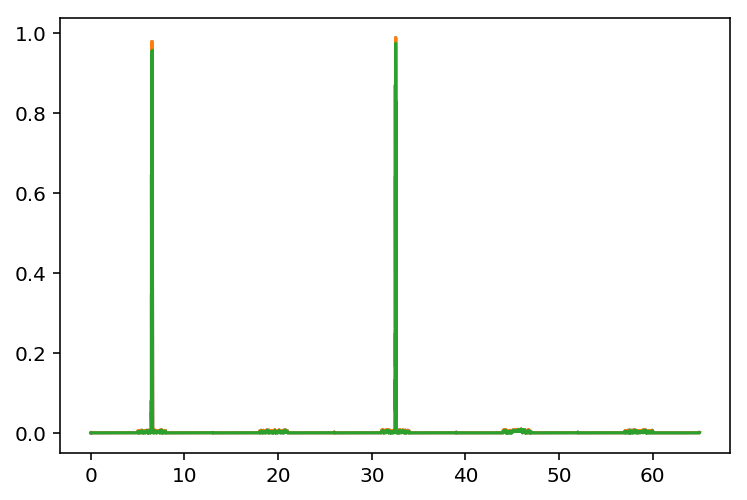

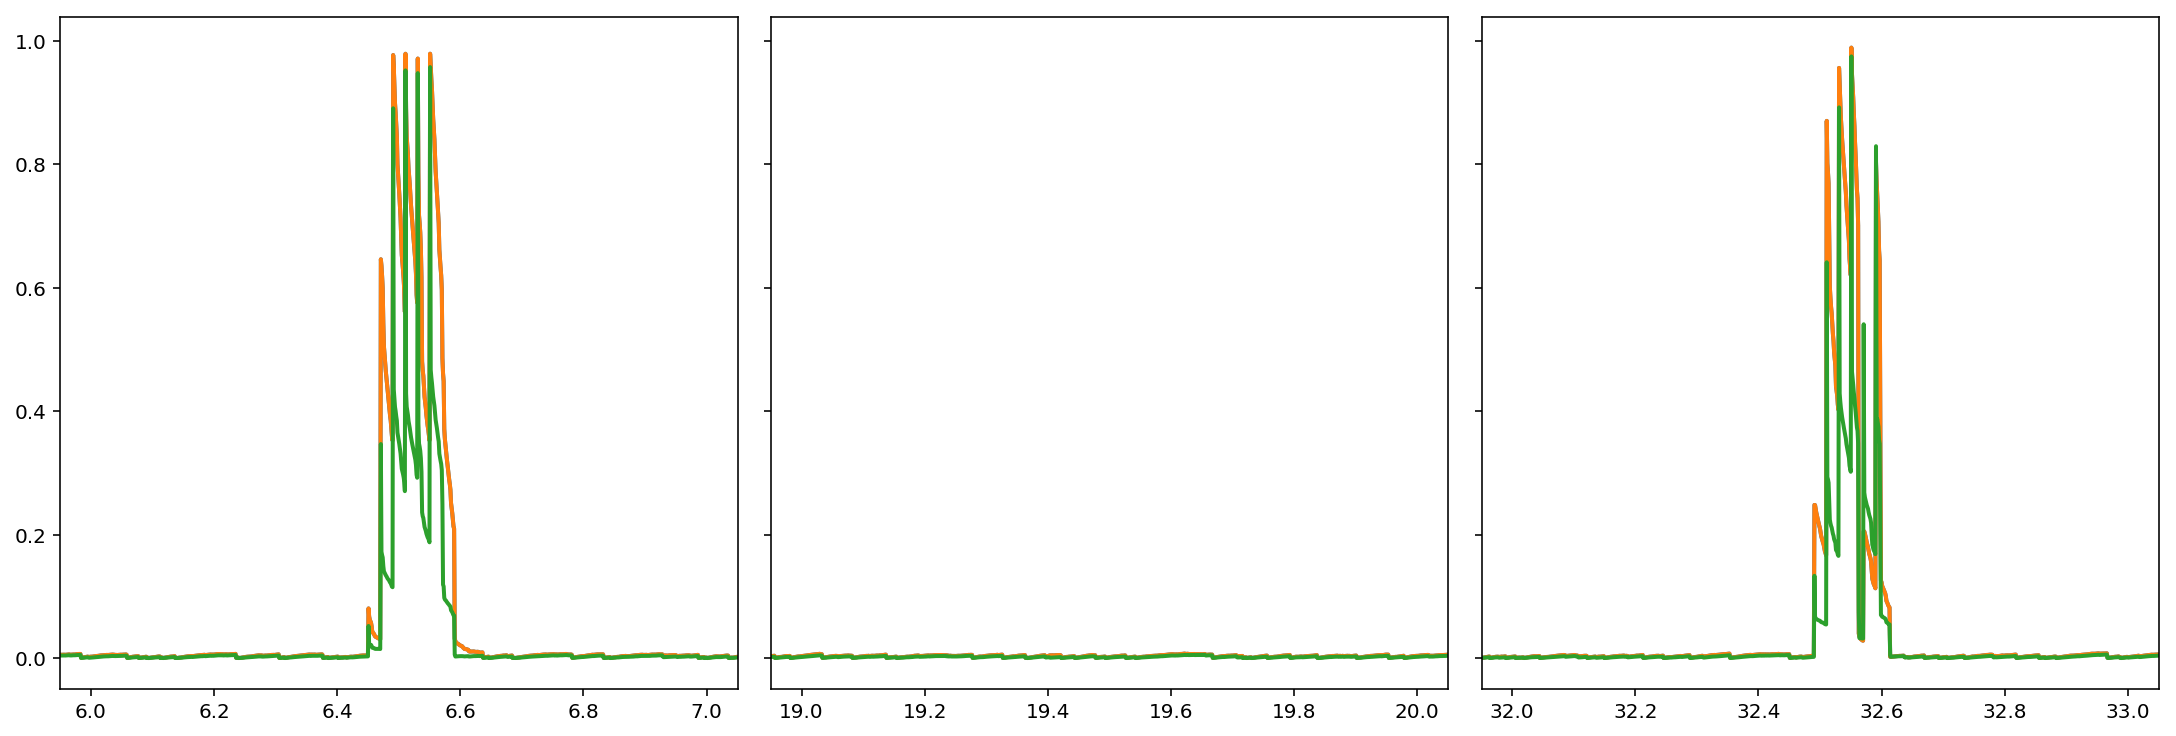

In [210]:
from replay_identification.core import _filter, get_observed_position_bin

movement_state_transition = random_walk(
    place_bin_centers_, movement_var, is_track_interior,
    replay_speed=200)

continuous_state_transition = movement_state_transition.copy()[np.newaxis, np.newaxis, ...]
spiking_likelihood = fit_spiking_likelihood(
                    position, spikes, is_replay, place_bin_centers_,
                    spike_model_penalty, spike_model_knot_spacing)
spiking_likelihood = spiking_likelihood(spikes, position, no_spike_intensity=1E-40)

discrete_likelihood = spiking_likelihood[:, [0], 0] # (n_time, n_states)
continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)

likelihood = spiking_likelihood[:, [0, 2]].copy()
observed_position_bin = get_observed_position_bin(
            position, place_bin_edges_)

filter_posterior, state_probability, prior = _filter(
    likelihood, movement_state_transition, replay_state_transition,
    observed_position_bin)

continuous_posterior, state_probability2 = _causal_classify2(continuous_likelihood, discrete_likelihood,
                  continuous_state_transition, discrete_state_transition2)

discrete_likelihood = spiking_likelihood[:, :2, 0] # (n_time, n_states)
continuous_likelihood = spiking_likelihood[:, [2], :] # (n_time, n_states, n_bins)

continuous_posterior, state_probability3 = _causal_classify2(continuous_likelihood, discrete_likelihood,
                  continuous_state_transition, discrete_state_transition)

plt.figure()
plt.plot(data['time'], state_probability[:, 1])
plt.plot(data['time'], state_probability2[:, 1])
plt.plot(data['time'], state_probability3[:, 2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)
for ax, (start_time, end_time) in zip(axes, data['ripple_times']):
    ax.plot(data['time'], state_probability[:, 1], linewidth=2)
    ax.plot(data['time'], state_probability2[:, 1], linewidth=2)
    ax.plot(data['time'], state_probability3[:, 2], linewidth=2)
    ax.set_xlim((start_time - 0.5, end_time + 0.5))

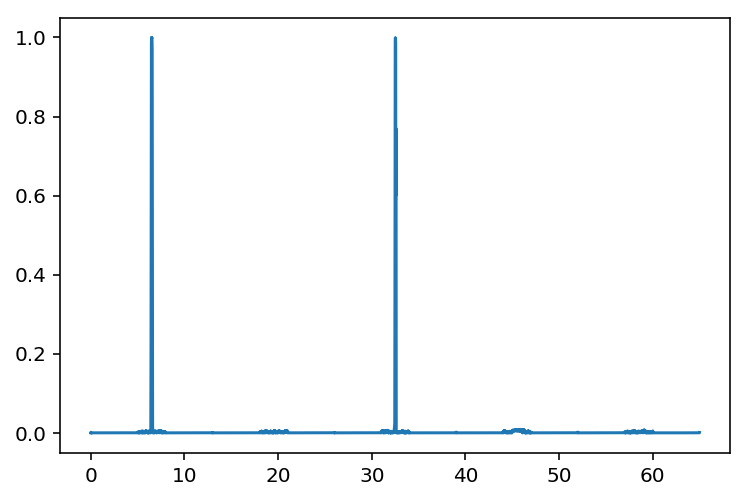

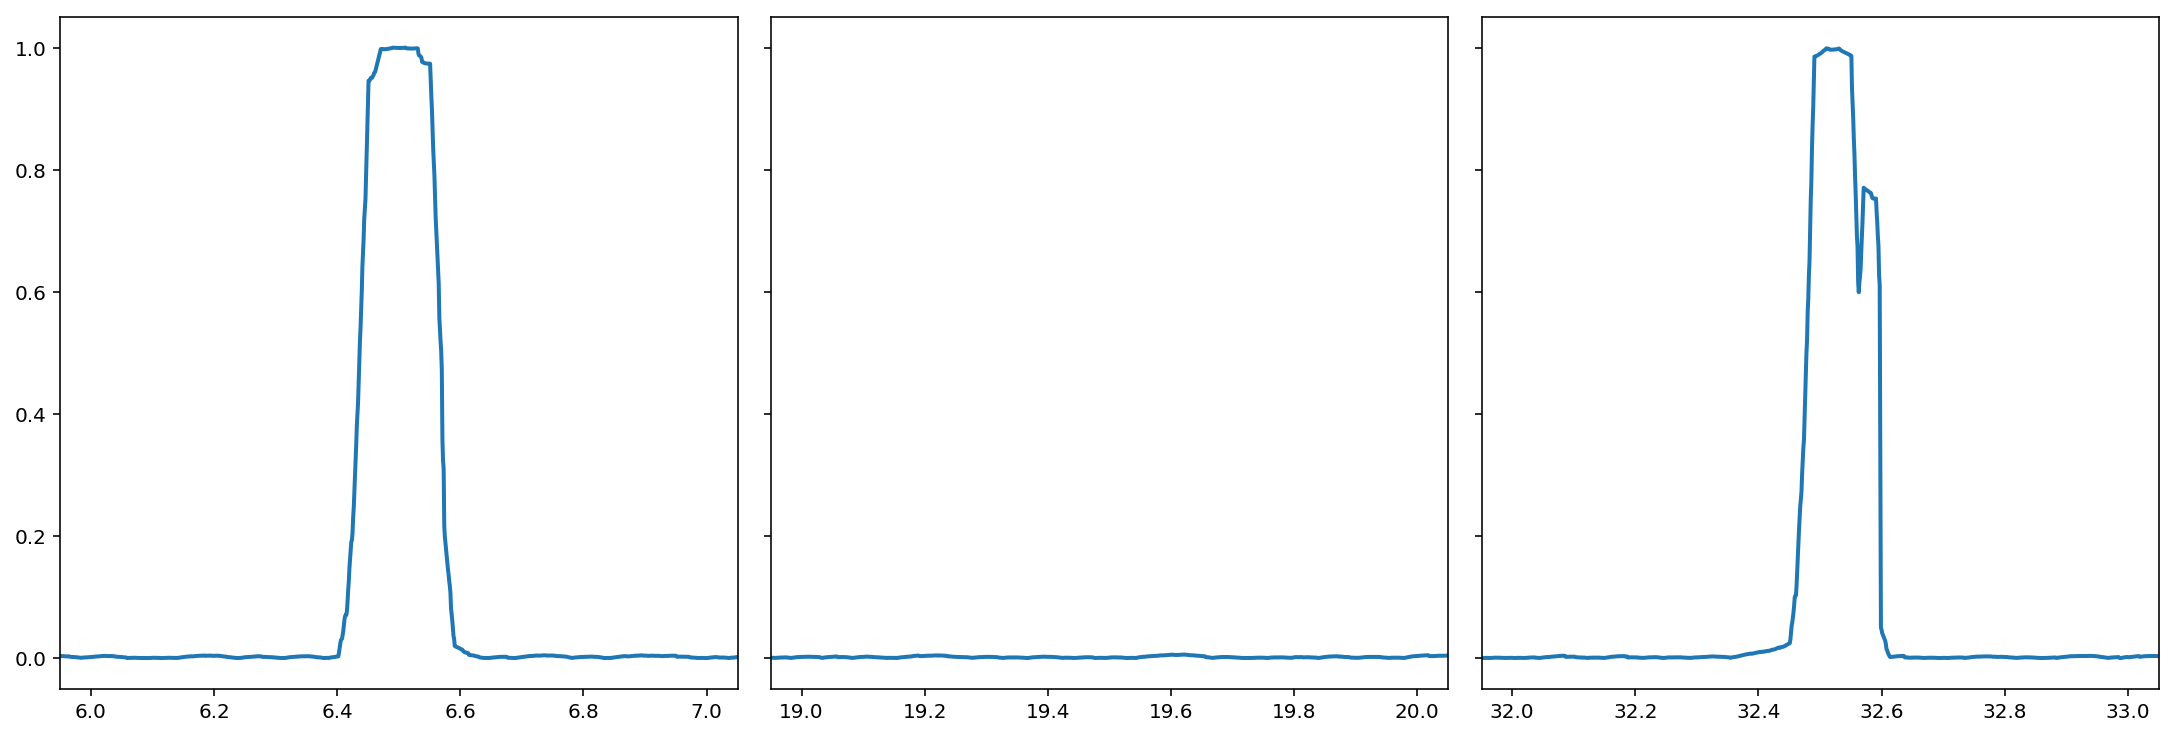

In [211]:
from replay_identification.core import _smoother

smoother_posterior, smoother_probability, smoother_prior, weights = _smoother(filter_posterior, movement_state_transition,
              replay_state_transition, observed_position_bin)

plt.figure()
plt.plot(data['time'], smoother_probability[:, 1])
# plt.plot(data['time'], state_probability2[:, 1])
# plt.plot(data['time'], state_probability3[:, 2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)
for ax, (start_time, end_time) in zip(axes, data['ripple_times']):
    ax.plot(data['time'], smoother_probability[:, 1], linewidth=2)
#     ax.plot(data['time'], state_probability2[:, 1], linewidth=2)
#     ax.plot(data['time'], state_probability3[:, 2], linewidth=2)
    ax.set_xlim((start_time - 0.5, end_time + 0.5))